# Basic setup and declare libaries

In [1]:
# Kiểm tra cấu hình GPU
!nvidia-smi

Fri May 12 11:41:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Khai báo thư viện
import torch
from IPython.display import Image
import shutil
import os
from random import choice

In [4]:
# Mount driver
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Prepare dataset

Get the dataset zip file to google colab

In [5]:
#link dataset: https://drive.google.com/file/d/1LEabVqQ3M5Lu5-pscWXzb1jo39DB_PDu/view?usp=share_link

# Removing the dataset and cloned yolo files if they exist already
!rm -f TrafficSign_detection.zip
!rm -rf TrafficSign_detection
%cd /content
!cp /content/drive/MyDrive/Mastercourse/TrafficSign_detection.zip /content
!unzip TrafficSign_detection.zip

/content
Archive:  TrafficSign_detection.zip
   creating: TrafficSign_detection/
  inflating: TrafficSign_detection/classes.names  
   creating: TrafficSign_detection/dataTest/
  inflating: TrafficSign_detection/dataTest/00860.jpg  
  inflating: TrafficSign_detection/dataTest/00862.jpg  
  inflating: TrafficSign_detection/dataTest/00863.jpg  
  inflating: TrafficSign_detection/dataTest/00864.jpg  
  inflating: TrafficSign_detection/dataTest/00865.jpg  
  inflating: TrafficSign_detection/dataTest/00866.jpg  
  inflating: TrafficSign_detection/dataTest/00867.jpg  
  inflating: TrafficSign_detection/dataTest/00868.jpg  
  inflating: TrafficSign_detection/dataTest/00869.jpg  
  inflating: TrafficSign_detection/dataTest/00870.jpg  
  inflating: TrafficSign_detection/dataTest/00871.jpg  
  inflating: TrafficSign_detection/dataTest/00872.jpg  
  inflating: TrafficSign_detection/dataTest/00874.jpg  
  inflating: TrafficSign_detection/dataTest/00876.jpg  
  inflating: TrafficSign_detection/data

Prepare train and validation data

In [6]:
# arrays to store file names
imgs = []
xmls = []

# create train and val folder
train_path = "/content/dataset/images/train"
val_path = "/content/dataset/images/val"

# data path
crs_path = "/content/TrafficSign_detection/ts"

train_ratio = 0.8
val_ratio = 0.2

# total count of imgs
total_img_count = len(os.listdir(crs_path))/2

# sorting count of imgs
for (dirname,dirs, files) in os.walk(crs_path):
#     print(files)
    for filename in files:
#         print("hello")
        if filename.endswith(".txt"):
            xmls.append(filename)
        else:
            imgs.append(filename)

# counting range for cycles
count_for_train = int(len(imgs)*train_ratio)
count_for_val = int(len(imgs)*val_ratio)
print("training images are : ",count_for_train)
print("validation images are : ",count_for_val)

training images are :  568
validation images are :  142


In [7]:
len(imgs)

710

In [8]:
# Seperate Image and label of Train and Val data

train_image_path = "/content/dataset/images/train"
train_label_path = "/content/dataset/labels/train"
val_image_path = "/content/dataset/images/val"
val_label_path = "/content/dataset/labels/val"

if not os.path.isdir(train_image_path):
    os.makedirs(train_image_path)
if not os.path.isdir(train_label_path):
    os.makedirs(train_label_path)
if not os.path.isdir(val_image_path):
    os.makedirs(val_image_path)
if not os.path.isdir(val_label_path):
    os.makedirs(val_label_path)

# cycle for train dir
for x in range(count_for_train):
    file_jpg = choice(imgs)
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(train_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(train_label_path,file_xml))
    
    imgs.remove(file_jpg)
    xmls.remove(file_xml)
    
# cycle for test dir
for x in range(count_for_val):
    file_jpg = choice(imgs)
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(val_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(val_label_path,file_xml))
    
    imgs.remove(file_jpg)
    xmls.remove(file_xml)

# rest of files
print("images length - ",len(imgs))
print(imgs,xmls)
for x in imgs:
    file_jpg = x
    file_xml = file_jpg[:-4] + ".txt"
    
    shutil.copy(os.path.join(crs_path,file_jpg),os.path.join(val_image_path,file_jpg))
    shutil.copy(os.path.join(crs_path,file_xml),os.path.join(val_label_path,file_xml))
# shutil.copytree(crs_path,val_path)

images length -  0
[] []


# Prepare YoloV5 Model

In [12]:
#  go to our data folder
!cd /content/TrafficSign_detection

#Cloning YoloV5 git Repo
!git clone https://github.com/ultralytics/yolov5

%cd yolov5

#Installing YoloV5 requirements files
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 15656, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 15656 (delta 137), reused 175 (delta 98), pack-reused 15393
Receiving objects: 100% (15656/15656), 14.65 MiB | 26.18 MiB/s, done.
Resolving deltas: 100% (10665/10665), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


Create a dataset.yaml

In [9]:
import yaml

In [10]:
dict_file = {'train':'/content/dataset/images/train' ,
            'val': '/content/dataset/images/val',
            'nc' : '4',
            'names' : ['prohibitory','danger','mandatory','other']}

In [13]:
with open('data/dataset.yaml', 'w+') as file:
    documents = yaml.dump(dict_file, file)
    lines = file.readlines()
    print(lines)

[]


# Training YoloV5 Model 

In [14]:
# Train with 50 epochs, 2 workers
!wandb disabled
!python train.py --img 415 --batch 16 --epochs 40 --data  data/dataset.yaml --weights yolov5s.pt --cache --workers 2

/bin/bash: wandb: command not found
train: weights=yolov5s.pt, cfg=, data=data/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=40, batch_size=16, imgsz=415, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma

# Make Predictions on dataTest

With simple data

In [16]:
!python detect.py --source /content/TrafficSign_detection/dataTest/00885.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/TrafficSign_detection/dataTest/00885.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/TrafficSign_detection/dataTest/00885.jpg: 384x640 1 mandatory, 1 other, 41.3ms
Speed: 0.5ms pre-process, 41.3ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


In [17]:
!python detect.py --source /content/TrafficSign_detection/dataTest/00862.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/TrafficSign_detection/dataTest/00862.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/TrafficSign_detection/dataTest/00862.jpg: 384x640 1 prohibitory, 49.6ms
Speed: 0.6ms pre-process, 49.6ms inference, 1.6ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp3


With complex data

In [18]:
!python detect.py --source /content/TrafficSign_detection/dataTest/test1.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt
!python detect.py --source /content/TrafficSign_detection/dataTest/test2.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt
!python detect.py --source /content/TrafficSign_detection/dataTest/test3.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt
!python detect.py --source /content/TrafficSign_detection/dataTest/test4.jpg --weights /content/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/TrafficSign_detection/dataTest/test1.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-165-ge382d4c Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7020913 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/TrafficSign_detection/dataTest/test1.jpg: 384x640 5 prohibitorys, 2 dangers, 61.6ms
Speed: 0.6ms pre-process, 61.6ms inference, 1.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp4
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], sourc

# Displaying and results

With validation data

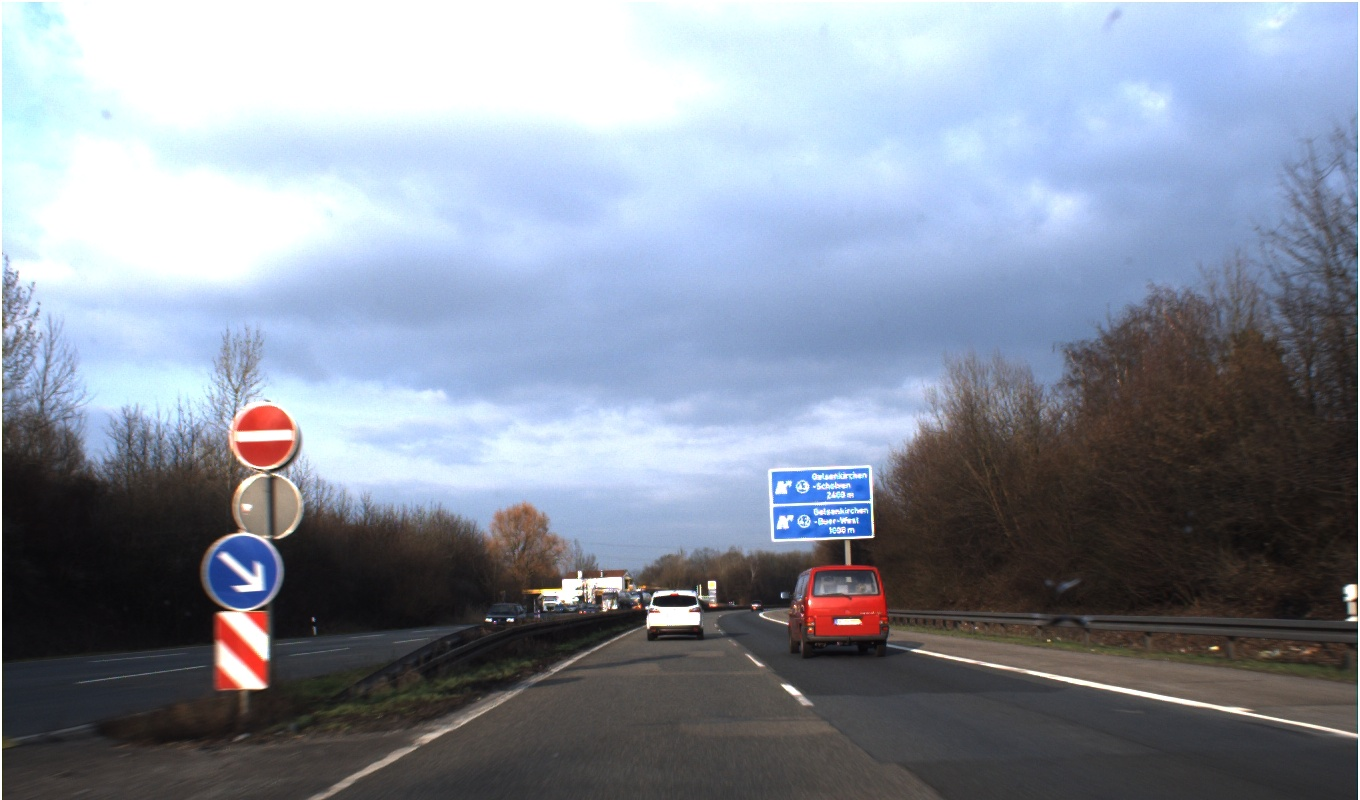

In [20]:
Image(filename='/content/TrafficSign_detection/dataTest/00885.jpg', width=416)

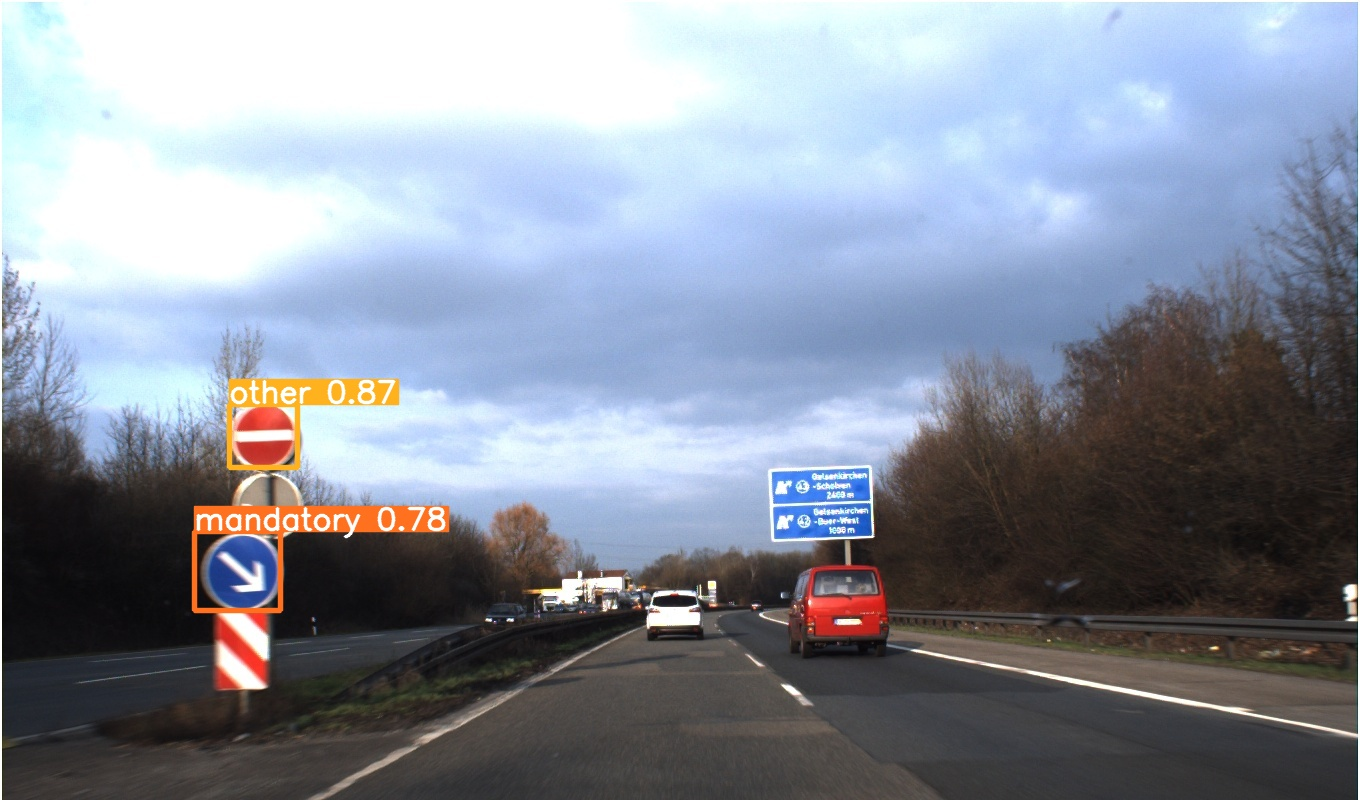

In [21]:
Image(filename='./runs/detect/exp2/00885.jpg', width=416)

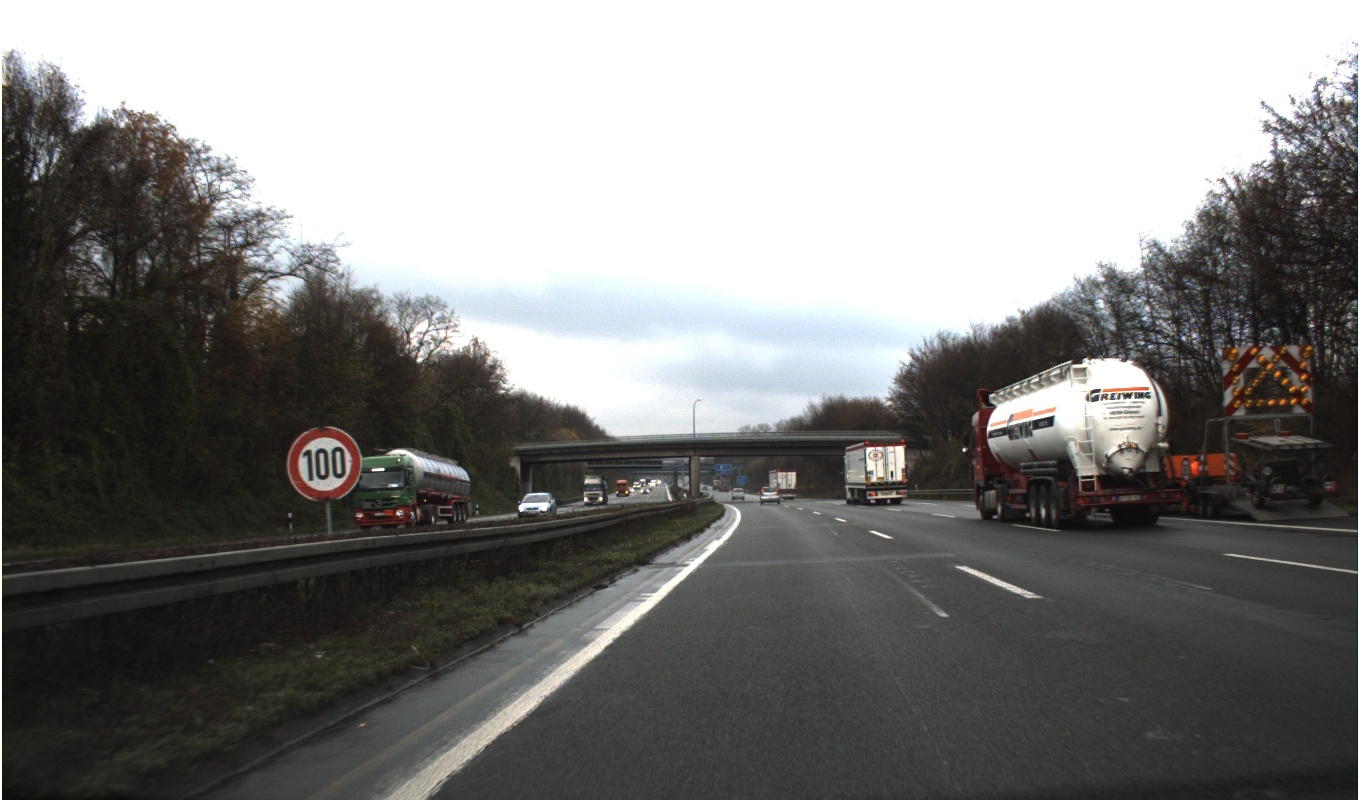

In [25]:
Image(filename='/content/TrafficSign_detection/dataTest/00862.jpg', width=416)

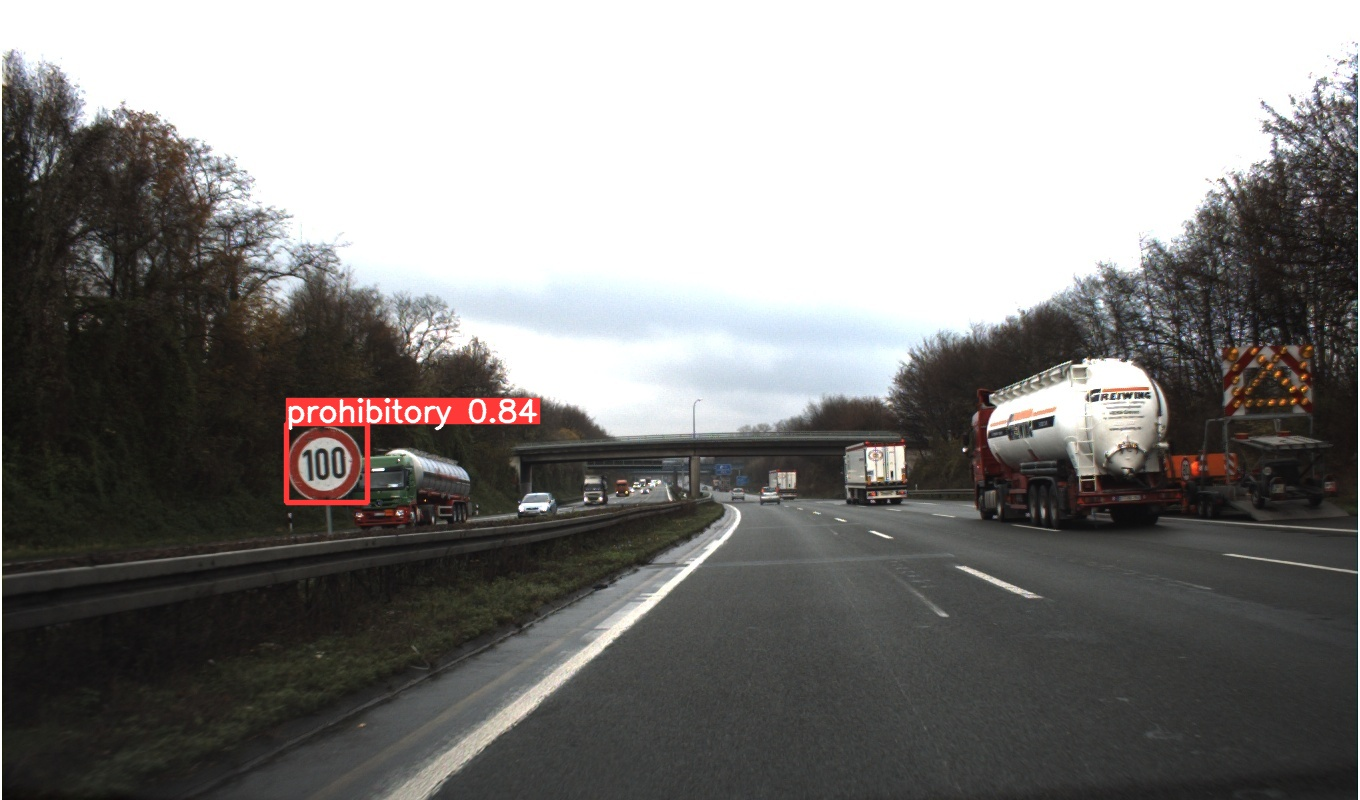

In [26]:
Image(filename='./runs/detect/exp3/00862.jpg', width=416)

With Test data

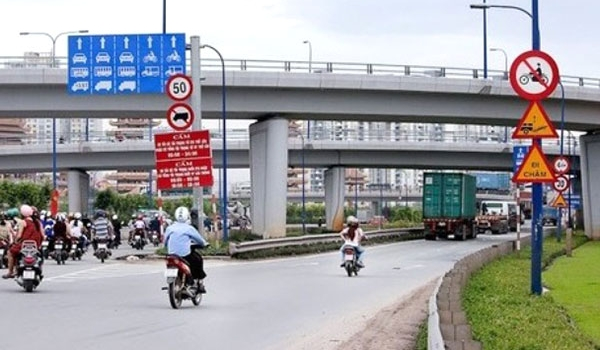

In [22]:
Image(filename='/content/TrafficSign_detection/dataTest/test1.jpg', width=416)

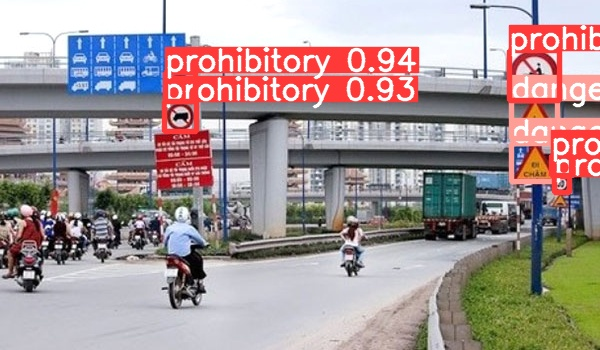

In [24]:
Image(filename='./runs/detect/exp4/test1.jpg', width=416)

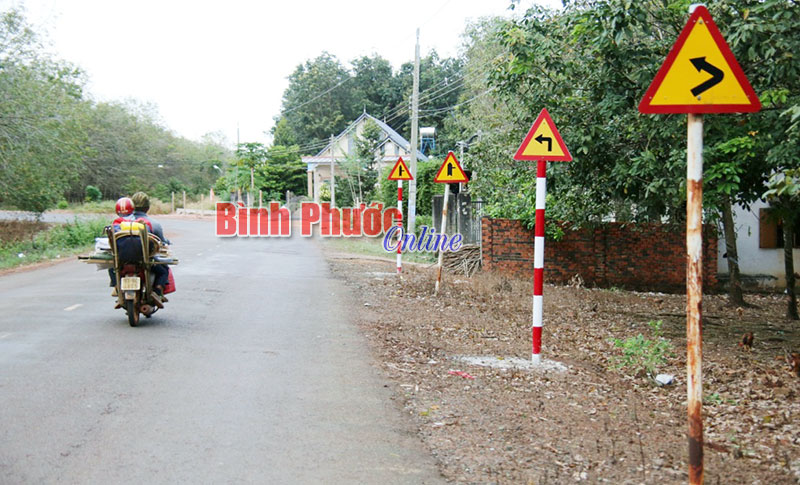

In [27]:
Image(filename='/content/TrafficSign_detection/dataTest/test2.jpg', width=416)

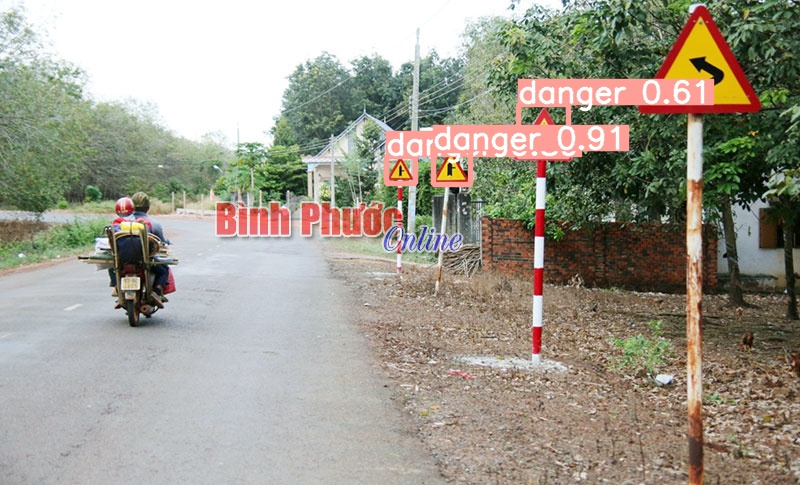

In [28]:
Image(filename='./runs/detect/exp5/test2.jpg', width=416)

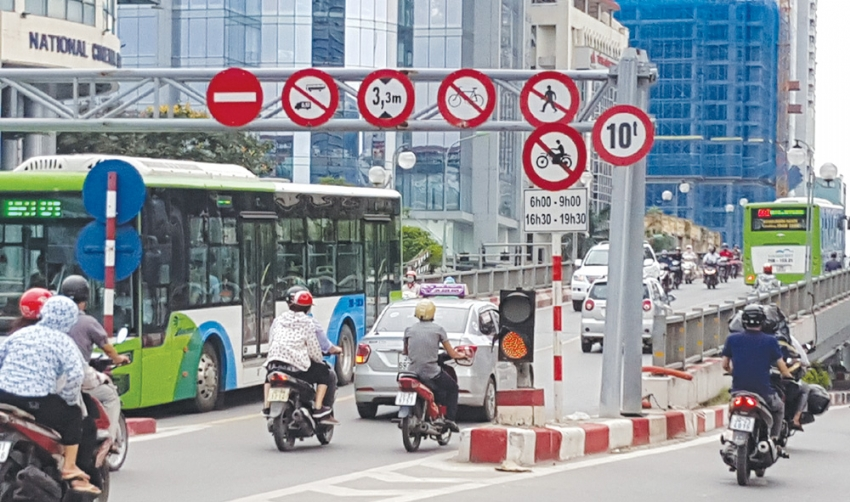

In [29]:
Image(filename='/content/TrafficSign_detection/dataTest/test3.jpg', width=416)

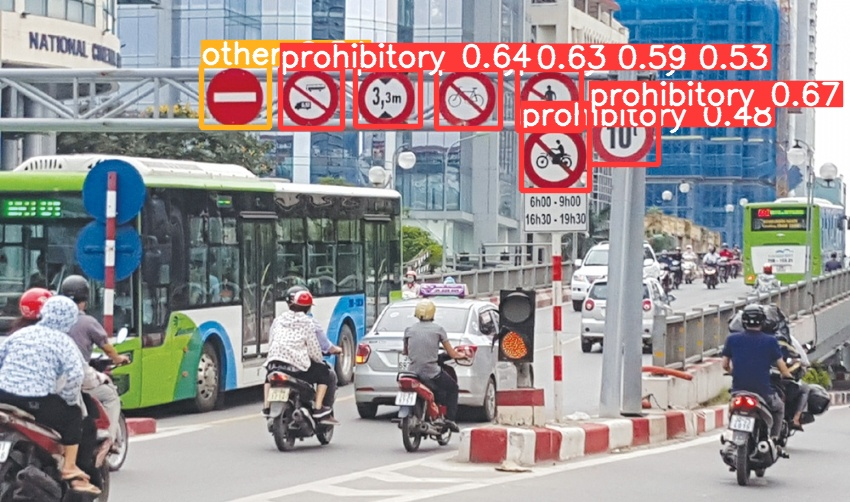

In [30]:
Image(filename='./runs/detect/exp6/test3.jpg', width=416)

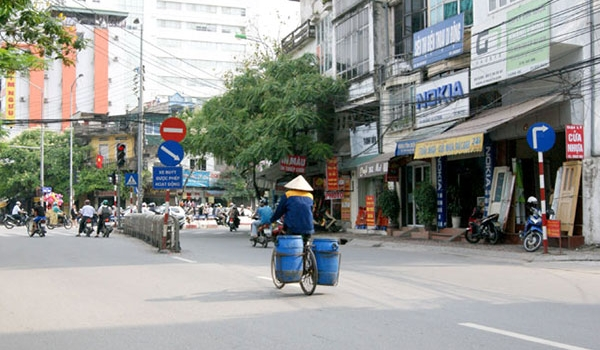

In [31]:
Image(filename='/content/TrafficSign_detection/dataTest/test4.jpg', width=416)

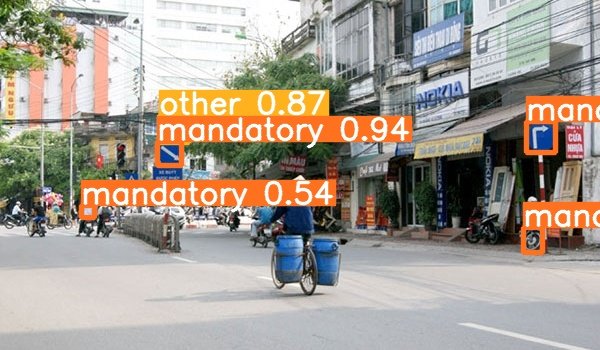

In [32]:
Image(filename='./runs/detect/exp7/test4.jpg', width=416)